In this exploratory analysis, I aim to profile early dendritic cell maturation. I wanted to explore which genes are differentially expressed upon dendritic cell maturation, reducing dimensionality on key genes that differentiate them. 

In [2]:
import numpy as np
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
subprocess.run("gunzip GSE288378_Normalized_Gene_Counts.csv.gz", shell=True)

gunzip: can't stat: GSE288378_Normalized_Gene_Counts.csv.gz (GSE288378_Normalized_Gene_Counts.csv.gz.gz): No such file or directory


CompletedProcess(args='gunzip GSE288378_Normalized_Gene_Counts.csv.gz', returncode=1)

In [3]:
'''
Raw data processing

source = https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE288378
- collecting normal non mature vs. normal mature
'''
df = pd.read_csv("GSE288378_Normalized_Gene_Counts.csv")

# gene name as index
df = df.set_index("Unnamed: 0")
far_from_blood_vessels = df.loc[:, df.columns.str.contains("neg")]

In [4]:
immature_DC = far_from_blood_vessels.loc[:, far_from_blood_vessels.columns.str.contains("Naive")]
mature_DC = far_from_blood_vessels.loc[:, far_from_blood_vessels.columns.str.contains("CpG6")]

# making samples equal in replicates
mature_DC = mature_DC.drop(columns = ['CpG6hrs_IVneg_res_cDC1_1'])

average_mature = mature_DC
average_immature = immature_DC
average_mature.columns = [f"mature_{i}" for i in range(len(average_mature.columns))]
average_immature.columns = [f"immature_{i}" for i in range(len(average_immature.columns))]
all = pd.concat([average_mature, average_immature], axis=1)

<h1>Boxplot</h1>

Text(0, 0.5, 'Read Count')

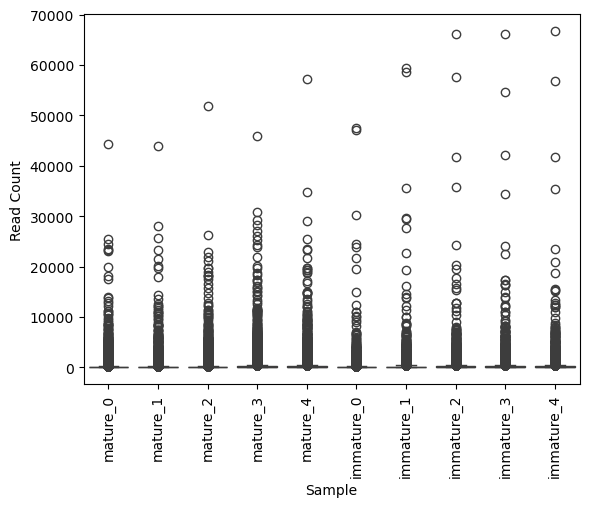

In [5]:
sns.boxplot(all)
plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Read Count")

In [6]:
def log2_fold_change(df, col1, col2):
    """
    Calculate log2 fold change between two columns in a Pandas DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing expression values.
        col1 (str): Name of the first column (e.g., control group).
        col2 (str): Name of the second column (e.g., treatment group).
        
    Returns:
        pd.Series: A Series containing log2 fold change values.
    """
    return np.log2(df[col2] / df[col1])

In [7]:
'''
Obtaining top 25 differentially regulated genes
'''
avgs = pd.DataFrame({"mature":average_mature.transpose().mean(), "immature":average_immature.transpose().mean()})
avgs
avgs = avgs.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
avgs['fc'] = log2_fold_change(avgs, "immature", "mature" )

# correcting for positive and negative infinity
avgs = avgs.replace(np.inf, np.nan).dropna()
avgs = avgs.replace(-np.inf, np.nan).dropna()

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
'''
Wilcoxon's Rank Sum Test
'''
import scipy.stats as sts
sts.wilcoxon(avgs['mature'], avgs['immature']).pvalue 

1.3140859462657296e-236

In [9]:
topupregulated = np.array(avgs["fc"].nlargest(25).index)
topdownregulated = np.array(avgs["fc"].nsmallest(25).index)

<h3>Merging top differentially expressed genes</h3>

Each gene list is printed and copy/pasted.

In [11]:
topupregulated

array(['Pdzk1ip1', 'Krt222', 'Il27', 'Gm14207', 'Cxcl3', 'Olfr231', 'Ubd',
       'Vgf', 'Gm12606', 'Myl7', 'Ocln', 'Pla1a', 'Coch', 'Fam89a',
       'BC023105', 'Car13', 'Mylk', '1700011B04Rik', 'Sct', 'Ndrg2',
       'Eps8l2', 'Wfdc21', 'Pla2g4f', 'Dll4', 'Arhgap8'], dtype=object)

In [12]:
topdownregulated

array(['Csf1r', 'Cd209d', 'Mgl2', 'Cx3cr1', 'Cd209e', 'Emilin2', 'Skint3',
       'Clec10a', 'Cfh', 'Tmem231', 'Ctnnd2', 'Alox5ap', 'Chil5',
       'Clec4g', 'Clec4b2', 'Cd207', 'Septin3', 'Cd300lb', 'Aldh3b1',
       'Pianp', 'Plekhg3', 'Cd209b', 'Gsg1', 'Slc6a12', 'Sgsh'],
      dtype=object)

In [13]:
topgenes = ['Pdzk1ip1', 'Krt222', 'Il27', 'Gm14207', 'Cxcl3', 'Olfr231', 'Ubd',
       'Vgf', 'Gm12606', 'Myl7', 'Ocln', 'Pla1a', 'Coch', 'Fam89a',
       'BC023105', 'Car13', 'Mylk', '1700011B04Rik', 'Sct', 'Ndrg2',
       'Eps8l2', 'Wfdc21', 'Pla2g4f', 'Dll4', 'Arhgap8',
       'Csf1r', 'Cd209d', 'Mgl2', 'Cx3cr1', 'Cd209e', 'Emilin2', 'Skint3',
       'Clec10a', 'Cfh', 'Tmem231', 'Ctnnd2', 'Alox5ap', 'Chil5',
       'Clec4g', 'Clec4b2', 'Cd207', 'Septin3', 'Cd300lb', 'Aldh3b1',
       'Pianp', 'Plekhg3', 'Cd209b', 'Gsg1', 'Slc6a12', 'Sgsh']

<h1>Heatmap</h1>

In [15]:
'''
Calculating log 2 Foldchange by samples
'''
mature_DC
fcdf = pd.DataFrame()
for i in range(len(mature_DC.columns)):
    fcdf[f"sample_{i}"] = log2_fold_change(all, f"mature_{i}", f"immature_{i}")

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
'''
Correcting for more than 3 samples being present
'''
viz = fcdf.loc[topgenes][fcdf.loc[topgenes].transpose().count() >3]
newviz = viz[viz.replace(np.inf, np.nan).transpose().count()>3]

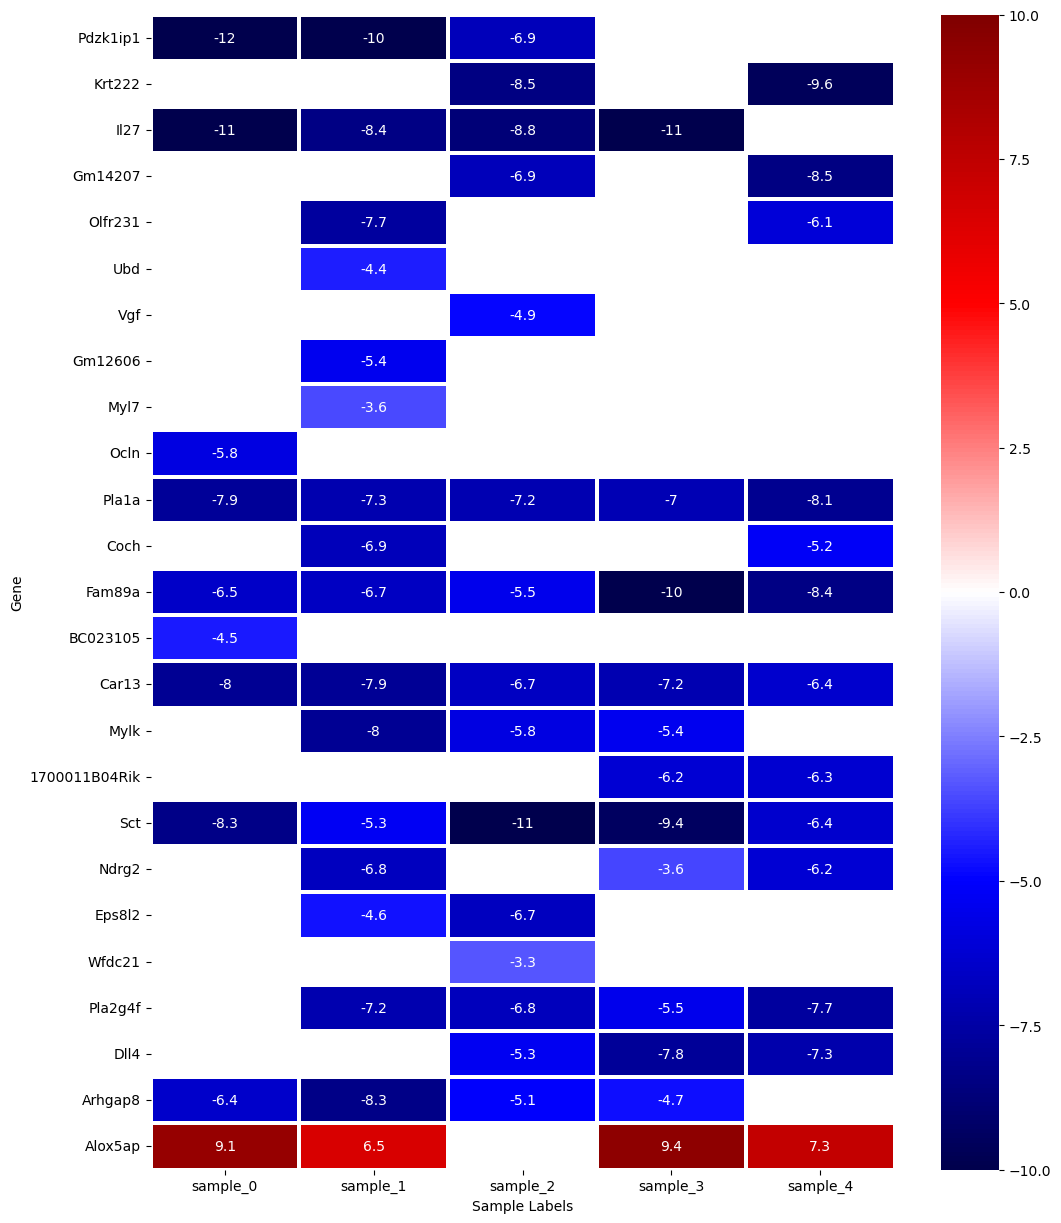

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 15))  # Adjust width and height as needed
sns.heatmap(newviz, linewidth=1.5, annot=True, cmap='seismic', vmin=-10, vmax=10)
plt.xlabel("Sample Labels")
plt.ylabel("Gene")
plt.show()


<h1>PCA</h1>

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
# Reformatting data
data = {
    "sample_0": [9.126704, -11.799282, -10.798472, 0.000000, 0.000000, 0.000000, -7.871787, 0.000000, -5.807355, 0.000000, 0.000000, 0.000000, -7.988117, -8.338736, -6.549464, -6.445015, 0.000000, 0.000000, -5.280461, 0.000000],
    "sample_1": [6.527043, -10.489848, -8.417853, 0.000000, -4.426265, 0.000000, -7.261050, -6.894818, 0.000000, -3.584963, -6.781360, -7.977280, -7.916211, -5.274931, -6.717676, -8.312883, -4.624491, 0.000000, -6.711954, -7.219169],
    "sample_2": [0.000000, -6.909293, -8.774238, -8.503826, 0.000000, -4.906891, -7.159871, 0.000000, 0.000000, 0.000000, 0.000000, -5.832890, -6.696581, -10.684749, -5.494522, -5.058894, -6.727920, -3.321928, 0.000000, -6.825971],
    "sample_3": [9.411511, 0.000000, -10.868051, 0.000000, 0.000000, 0.000000, -7.046821, 0.000000, 0.000000, 0.000000, -3.614710, -5.403722, -7.178042, -9.397033, -10.340963, -4.714246, 0.000000, 0.000000, 0.000000, -5.487036],
    "sample_4": [7.269127, 0.000000, 0.000000, -9.605480, 0.000000, 0.000000, -8.091435, -5.196397, 0.000000, 0.000000, -6.247928, 0.000000, -6.364420, -6.379997, -8.367779, 0.000000, 0.000000, 0.000000, -7.087463, 0.000000]
}

genes = ["Alox5ap", "Pdzk1ip1", "Il27", "Krt222", "Ubd", "Vgf", "Pla1a", "Coch", "Ocln", "Myl7", 
         "Ndrg2", "Mylk", "Car13", "Sct", "Fam89a", "Arhgap8", "Eps8l2", "Wfdc21", "Hc", "Pla2g4f"]

df = pd.DataFrame(data, index=genes)

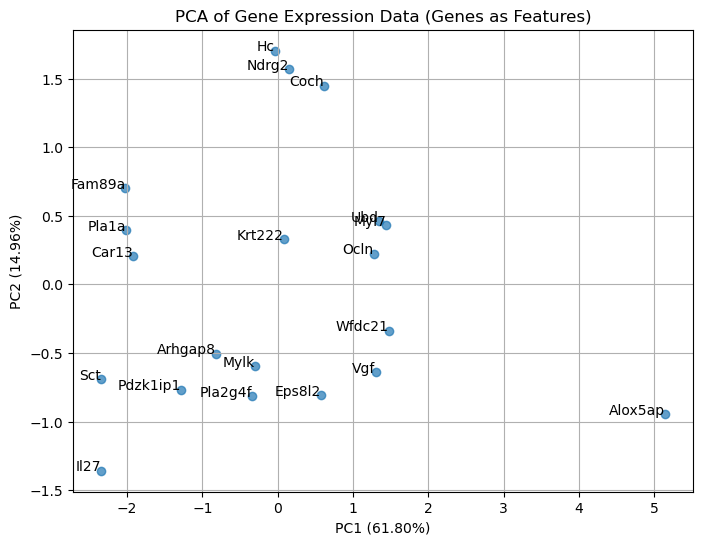

array([0.61800209, 0.14959766])

In [21]:
# Transpose data to have genes as rows and samples as columns for PCA on genes
scaler = StandardScaler()
df_scaled_genes = scaler.fit_transform(df)  # Standardize genes instead of samples

# Perform PCA on genes
pca_genes = PCA(n_components=2)
principal_components_genes = pca_genes.fit_transform(df_scaled_genes)

# Create a PCA DataFrame for genes
pca_genes_df = pd.DataFrame(principal_components_genes, columns=["PC1", "PC2"], index=df.index)

# Plot PCA results for genes
plt.figure(figsize=(8,6))
plt.scatter(pca_genes_df["PC1"], pca_genes_df["PC2"], alpha=0.7)
for gene, (x, y) in pca_genes_df.iterrows():
    plt.text(x, y, gene, fontsize=10, ha='right')
plt.xlabel(f"PC1 ({pca_genes.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca_genes.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA of Gene Expression Data (Genes as Features)")
plt.grid(True)
plt.show()

# Variance explained by each principal component for genes
pca_genes.explained_variance_ratio_

<h1>GSEA</h1>

In [23]:
'''
Filling all na values
'''
newnewviz = newviz.replace(-np.inf, np.nan).replace(np.inf, np.nan)
newviz = newnewviz.fillna(0)

In [52]:
# Jackson Laboratory mouse-human ortholog database
database = pd.read_csv("https://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt", 
           delimiter='\t')

mouse = database[database["Common Organism Name"] == "mouse, laboratory"][['DB Class Key','Symbol']]
human = database[database["Common Organism Name"] == "human"][['DB Class Key','Symbol']]

common = np.intersect1d(mouse.set_index('DB Class Key').index, human.set_index('DB Class Key').index)

In [53]:
nonempty_genes = ['Gm14207', 'Olfr231', 'Gm12606', 'BC023105', '1700011B04Rik']
topgenes = [topgenes[i] for i in range(len(topgenes)) if topgenes[i] not in nonempty_genes]

In [59]:
mouse.set_index('Symbol').loc[topgenes].values.flatten()

array([48574725, 48577353, 48584777, 48569527, 48587403, 48572427,
       48569281, 48575168, 48579585, 48578414, 48582438, 48568112,
       48572470, 48586764, 48573754, 48576228, 48587493, 48578112,
       48576914, 48583561, 48569084, 48582366, 48567710, 48568976,
       48582724, 48570382, 48588768, 48567711, 48574086, 48569149,
       48569485, 48572684, 48569119, 48584020, 48587902, 48583910,
       48575930, 48577169, 48567492, 48572345, 48583364, 48582727,
       48584600, 48570607, 48579529])

In [74]:
human.set_index('DB Class Key', inplace=True)

In [78]:
# value from above pasted
human.loc[[48574725, 48577353, 48584777, 48569527, 48587403, 48572427,
       48569281, 48575168, 48579585, 48578414, 48582438, 48568112,
       48572470, 48586764, 48573754, 48576228, 48587493, 48578112,
       48576914, 48583561, 48569084, 48582366, 48567710, 48568976,
       48582724, 48570382, 48567711, 48574086, 48569149,
       48569485, 48572684, 48569119, 48584020, 48583910,
       48575930, 48577169, 48567492, 48572345, 48583364, 48582727,
       48584600, 48570607, 48579529]].values.flatten()
# popped  48588768, 48587902 due to no human ortholog

array(['PDZK1IP1', 'KRT222', 'IL27', 'CXCL1', 'CXCL2', 'CXCL3', 'UBD',
       'VGF', 'MYL7', 'OCLN', 'PLA1A', 'COCH', 'FAM89A', 'CA13', 'MYLK',
       'SCT', 'NDRG2', 'EPS8L2', 'WFDC21P', 'PLA2G4F', 'DLL4', 'ARHGAP8',
       'PRR5-ARHGAP8', 'CSF1R', 'CD209', 'CLEC10A', 'CX3CR1', 'CD209',
       'EMILIN2', 'CLEC10A', 'CFH', 'TMEM231', 'CTNND2', 'ALOX5AP',
       'CHIA', 'CLEC4G', 'CD207', 'SEPTIN3', 'CD300LB', 'ALDH3B1',
       'PIANP', 'PLEKHG3', 'CD209', 'CLEC4M', 'GSG1', 'SLC6A12', 'SGSH'],
      dtype=object)

In [80]:
humananalog = ['PDZK1IP1', 'KRT222', 'IL27', 'CXCL1', 'CXCL2', 'CXCL3', 'UBD',
       'VGF', 'MYL7', 'OCLN', 'PLA1A', 'COCH', 'FAM89A', 'CA13', 'MYLK',
       'SCT', 'NDRG2', 'EPS8L2', 'WFDC21P', 'PLA2G4F', 'DLL4', 'ARHGAP8',
       'PRR5-ARHGAP8', 'CSF1R', 'CD209', 'CLEC10A', 'CX3CR1', 'CD209',
       'EMILIN2', 'CLEC10A', 'CFH', 'TMEM231', 'CTNND2', 'ALOX5AP',
       'CHIA', 'CLEC4G', 'CD207', 'SEPTIN3', 'CD300LB', 'ALDH3B1',
       'PIANP', 'PLEKHG3', 'CD209', 'CLEC4M', 'GSG1', 'SLC6A12', 'SGSH']

In [82]:
import gseapy as gp
from gseapy import barplot
gene_list = humananalog

In [84]:
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

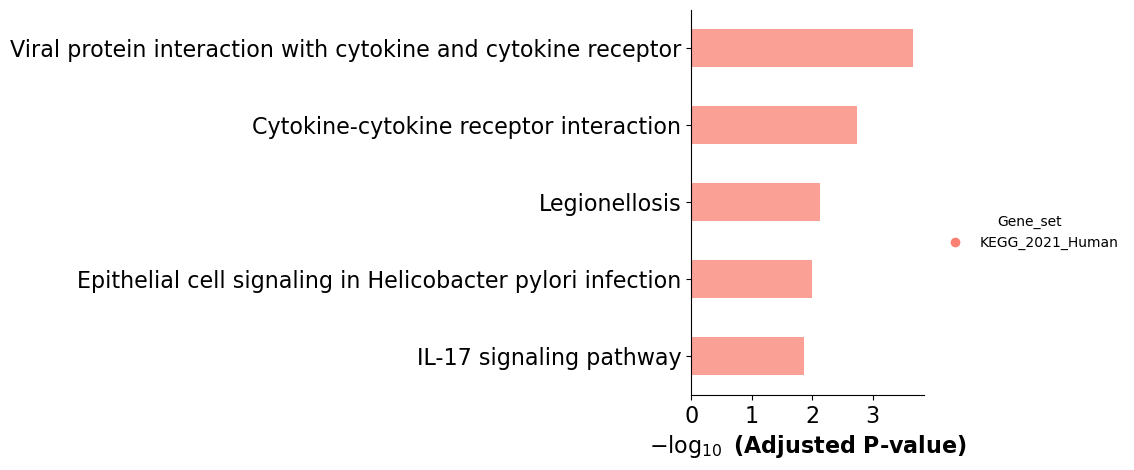

In [85]:
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              #color=['darkred', 'darkblue'] # set colors for group
              color = {'KEGG_2021_Human': 'salmon', 'MSigDB_Hallmark_2020':'darkblue'}
             )
